# Solvers for Additive-Noise SDEs
SDEs of the form
$$dX_t = f(t, X_t) \, dt + σ \, dW_t$$
are said to have additive noise, since the matrix $\sigma$ in the noise term is independent of $t$ and $X$. Such SDEs permit special solvers with a higher order of strong convergence than those for general SDEs. A few such solvers are presented below.

The high convergence rate of these solvers comes at the cost of requiring information about the Brownian motion's space-time Lévy area, defined as
$$
    H_{s,t} = \frac{1}{t-s}  \int_{s}^{t}  W_u - \frac{u - s}{t - s} W_{s,t} \; du.
$$
We modified the `VirtualBrownianTree` and the `UnsafeBrownianPath` to compute the increments of $H$ in addition to those of $W$. To enable this functionality, these objects must be initialised with `levy_area="space-time"`.


## Langevin diffusion
An example of an additive-noise SDE is the Langevin diffusion:
\begin{align*}
    d \mathbf{x}_t &= \mathbf{v}_t \, dt \\
    d \mathbf{v}_t &= - \gamma \, \mathbf{v}_t \, dt - u \,
    \nabla \! f( \mathbf{x}_t ) \, dt + \sqrt{2 \gamma u} \, d W_t.
\end{align*}

We use two examples of Langevin-type SDEs to demonstrate the operation of our solvers.


### A 2D Harmonic Oscillator
\begin{align*}
    d \mathbf{x}_t &= \mathbf{v}_t \, dt \\
    d \mathbf{v}_t &= - \gamma \, \mathbf{v}_t \, dt - u \, \mathbf{x}_t \, dt + \sqrt{2 \gamma u} \, d W_t
\end{align*}
where $\mathbf{x}_t, \mathbf{v}_t, W_t \in \mathbb{R}^2$.


### Particle in a Bistable Quartic Potential
\begin{align*}
    d x_t &= v_t \, dt \\
    d v_t &= - \gamma \, v_t \, dt - u \, \nabla \! f( x_t ) \, dt + \sqrt{2 \gamma u} \, d W_t
\end{align*}
where $x_t, v_t, W_t \in \mathbb{R}$ and $f(x) = (x-1)^2 (x+1)^2$.

### The "ULD3" Oscillator
Three particles in a 3D potential with three minima at (2, 2, 2), (-2, -2, -2) and (3, -1, 0).


In [1]:
import jax
from diffrax import AbstractBrownianPath, ControlTerm, MultiTerm, ODETerm
from diffrax._custom_types import Control, LevyVal, RealScalarLike, VF, Y
from jaxtyping import Array


%env JAX_PLATFORM_NAME=cpu

from test.helpers import (
    SDE,
    sde_solver_order,
)
from typing import Any, Callable, Literal, Union

import equinox as eqx
import jax.numpy as jnp
import jax.random as jr
import jax.tree_util as jtu
import matplotlib.pyplot as plt
from diffrax import (
    diffeqsolve,
    Euler,
    PIDController,
    SaveAt,
    SEA,
    ShARK,
    SRA1,
    StratonovichMilstein,
)
from jax import config


config.update("jax_enable_x64", True)
jnp.set_printoptions(precision=4, suppress=True)


# Plotting
def draw_order(hs, errs):
    plt.plot(1 / hs, errs)
    plt.yscale("log")
    plt.xscale("log")
    pretty_hs = ["{0:0.4f}".format(h) for h in hs]
    plt.xticks(ticks=1 / hs, labels=pretty_hs)
    plt.ylabel("RMS error")
    plt.xlabel("step size")
    plt.show()
    slope, _ = jnp.polyfit(jnp.log(hs), jnp.log(errs), 1)
    print(f"Order of convergence: {slope:.4f}")


def plot_sol(sol):
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.plot(sol.ts, sol.ys[0], label="x")
    ax.plot(sol.ts, sol.ys[1], label="v")
    # ax.set_ylim([-3.0, 3.0])
    ax.legend()
    plt.show()


def plot_sol3D(sol):
    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")
    x1 = sol.ys[0][:, :3]  # this is an Nx3 array which we want to plot
    x2 = sol.ys[0][:, 3:6]
    x3 = sol.ys[0][:, 6:]
    ax.plot(*x1.T, label="particle 1")
    ax.plot(*x2.T, label="particle 2")
    ax.plot(*x3.T, label="particle 3")
    ax.legend()
    plt.show()


# Define SDEs
def _langevin_drift(t, y, args):
    gamma, u, grad_f = args
    x, v = y
    d_x = v
    d_v = -gamma * v - u * grad_f(x)
    d_y = (d_x, d_v)
    return d_y


class _LangevinDiffusionTerm(ControlTerm):
    r"""Represents the diffusion term in the Langevin SDE:

    $d \mathbf{x}_t = \mathbf{v}_t \, dt$

    $d \mathbf{v}_t = - \gamma \, \mathbf{v}_t \, dt - u \,
    \nabla \! f( \mathbf{x}_t ) \, dt + \sqrt{2 \gamma u} \, d W_t.$
    """

    gamma: Array
    u: Array
    control: AbstractBrownianPath

    def __init__(self, gamma, u, control: AbstractBrownianPath):
        assert gamma.shape == u.shape
        self.gamma = gamma
        self.u = u
        self.control = control

        def vector_field(_, y: tuple, ___) -> tuple[Array, VF]:
            dtype = y[1].dtype
            d_v = jnp.sqrt(2 * gamma * u) * jnp.ones(y[1].shape, dtype=dtype)
            d_y = (jnp.zeros_like(d_v), d_v)
            return d_y

        super().__init__(vector_field, control)

    def contr(
        self, t0: RealScalarLike, t1: RealScalarLike, **kwargs
    ) -> Union[LevyVal, tuple[Array, Control]]:
        # Since the vector field is of the form (dx, dv) and since x is
        # not influenced by the Brownian motion, the PyTree structure of
        # the control must also be a tuple, with an arbitrary first entry.
        # Hence, this replaces all entries in the output of control with.
        if "use_levy" in kwargs and kwargs["use_levy"]:
            contr_out = self.control.evaluate(t0, t1, **kwargs)
            # for each entry of LevyVal, replace it with a tuple(0, entry)
            return jtu.tree_map(
                lambda lf: (jnp.zeros_like(lf), lf),
                contr_out,
            )
        else:
            contr_out = self.control.evaluate(t0, t1, **kwargs)
            return jnp.zeros_like(contr_out), contr_out

    def prod(self, vf: tuple[Any, VF], control: tuple[Any, Control]) -> tuple[Array, Y]:
        _, dv = vf
        _, dw = control
        out = dv * dw
        return jnp.zeros_like(out), out


class LangevinTerm(MultiTerm[tuple[ODETerm, ControlTerm]]):
    r"""Used to represent the Langevin SDE, given by:

    $d \mathbf{x}_t = \mathbf{v}_t \, dt$

    $d \mathbf{v}_t = - \gamma \, \mathbf{v}_t \, dt - u \,
    \nabla \! f( \mathbf{x}_t ) \, dt + \sqrt{2 \gamma u} \, d W_t.$

    where $\mathbf{x}_t, \mathbf{v}_t \in \mathbb{R}^d$ represent the position
    and velocity, $W$ is a Brownian motion in $\mathbb{R}^d$,
    $f: \mathbb{R}^d \rightarrow \mathbb{R}$ is a potential function, and
    $ \gamma,\, u\in\mathbb{R}^{d\times d}$ are diagonal matrices representing
    friction and a dampening parameter.
    """

    args: tuple[Array, Array, Callable[[Array], Array]] = eqx.field(static=True)

    def __init__(self, args, bm: AbstractBrownianPath):
        r"""**Arguments:**

        - `args`: a tuple of the form $(\gamma, \, u, \, \nabla \! f)$
        """
        g1, u1, grad_f = args
        gamma, u = jnp.broadcast_arrays(jnp.asarray(g1), jnp.asarray(u1))
        self.args = (gamma, u, grad_f)
        drift = ODETerm(lambda t, y, _: _langevin_drift(t, y, self.args))
        diffusion = _LangevinDiffusionTerm(gamma, u, bm)
        super().__init__(drift, diffusion)


def get_bqp(t0=0.3, t1=15.0, dtype=jnp.float32):
    grad_f_bqp = lambda x: 4 * x * (jnp.square(x) - 1)
    args_bqp = (dtype(0.8), dtype(0.2), grad_f_bqp)
    y0_bqp = (dtype(0), dtype(0))
    w_shape_bqp = ()

    def get_terms_bqp(bm):
        return LangevinTerm(args_bqp, bm)

    return SDE(get_terms_bqp, None, y0_bqp, t0, t1, w_shape_bqp)


def get_harmonic_oscillator(t0=0.3, t1=15.0, dtype=jnp.float32):
    gamma_hosc = jnp.array([2, 0.5], dtype=dtype)
    u_hosc = jnp.array([0.5, 2], dtype=dtype)
    args_hosc = (gamma_hosc, u_hosc, lambda x: 2 * x)
    x0 = jnp.zeros((2,), dtype=dtype)
    v0 = jnp.zeros((2,), dtype=dtype)
    y0_hosc = (x0, v0)
    w_shape_hosc = (2,)

    def get_terms_hosc(bm):
        return LangevinTerm(args_hosc, bm)

    return SDE(get_terms_hosc, None, y0_hosc, t0, t1, w_shape_hosc)


def get_uld3_langevin(t0=0.3, t1=15.0, dtype=jnp.float32):
    # Three particles in 3D space with a potential that has three local minima,
    # at (2, 2, 2), (-2, -2, -2) and (3, -1, 0).
    def single_particle_potential(x):
        assert x.shape == (3,)
        return 1.0 * (
            jnp.sum((x - 2.0 * jnp.ones((3,), dtype=dtype)) ** 2)
            * jnp.sum((x + 2.0 * jnp.ones((3,), dtype=dtype)) ** 2)
            * jnp.sum((x - jnp.array([3, -1, 0], dtype=dtype)) ** 2)
        )

    def potential(x):
        assert x.shape == (9,)
        return (
            single_particle_potential(x[:3])
            + single_particle_potential(x[3:6])
            + single_particle_potential(x[6:])
        )

    grad_potential = jax.grad(potential)

    def single_circ(x):
        assert x.shape == (3,)
        return 0.1 * jnp.array([x[1], -x[0], 0.0])

    def circular_term(x):
        assert x.shape == (9,)
        return jnp.concatenate(
            [
                single_circ(x[:3]),
                single_circ(x[3:6]),
                single_circ(x[6:]),
            ]
        )

    def grad_f(x):
        assert x.shape == (9,)
        # x0 and x1 will do a circular motion, so we will add a term of the form
        force = grad_potential(x) + circular_term(x)
        return 10.0 * force / (jnp.sum(jnp.abs(force)) + 10.0)

    u = 1.0
    gamma = 2.0
    args = (u, gamma, grad_f)
    x0 = jnp.array([-1, 0, 1, 1, 0, -1, 1, 0, -1], dtype=dtype)
    v0 = jnp.zeros((9,), dtype=dtype)
    y0_uld3 = (x0, v0)
    w_shape_uld3 = (9,)

    def get_terms_uld3(bm):
        return LangevinTerm(args, bm)

    return SDE(get_terms_uld3, None, y0_uld3, t0, t1, w_shape_uld3)


dtype = jnp.float64
key = jr.PRNGKey(2)
num_samples = 100
keys = jr.split(jr.PRNGKey(5678), num=num_samples)
hs1 = jnp.power(2.0, jnp.arange(-2, -8, -1, dtype=dtype))
hs2 = jnp.power(2.0, jnp.arange(-1, -10, -1, dtype=dtype))
hs3 = jnp.power(2.0, jnp.arange(-1, -6, -1, dtype=dtype))


def get_dtype(x):
    if type(x) in [int, float, str]:
        return type(x)
    else:
        return jnp.dtype(x)


t0, t1 = 0.3, 15.0
t_short = 5.1
t_long = 35.0
saveat = SaveAt(ts=jnp.linspace(t0, t1, 1000))
saveat_long = SaveAt(ts=jnp.linspace(t0, t_long, 1000))
dt0 = 0.1

t0_typed, t1_typed = dtype(0.3), dtype(15)
saveat_typed = SaveAt(ts=jnp.linspace(t0, t1, 1000, dtype=dtype))
dt0_typed = dtype(0.1)
levy_area: Literal["", "space-time", "space-time-time"] = "space-time"

hosc = get_harmonic_oscillator(t0, t1, dtype=dtype)
terms_hosc = hosc.get_terms(hosc.get_bm(key, levy_area=levy_area, tol=2**-10))
hosc_short = get_harmonic_oscillator(t0, t_short, dtype=dtype)

bqp = get_bqp(t0, t1, dtype=dtype)
terms_bqp = bqp.get_terms(bqp.get_bm(key, levy_area=levy_area, tol=2**-10))
bqp_short = get_bqp(t0, t_short, dtype=dtype)

uld3_long = get_uld3_langevin(t0, t_long, dtype=dtype)
terms_uld3_long = uld3_long.get_terms(
    uld3_long.get_bm(key, levy_area=levy_area, tol=2**-10)
)
uld3 = get_uld3_langevin(t0, t1, dtype=dtype)
uld3_short = get_uld3_langevin(t0, t_short, dtype=dtype)

env: JAX_PLATFORM_NAME=cpu


## ShARK
`ShARK` normally has strong order 1.5, but when applied to a Langevin SDE it has order 2. Can be used for any additive-noise SDE.
 It has a better local error than SRA1. Uses two evaluations of the vector-field per step.

Based on equation (6.1) in
    Foster, J., dos Reis, G., & Strange, C. (2023).
    High order splitting methods for SDEs satisfying a commutativity condition.
    arXiv [Math.NA] http://arxiv.org/abs/2210.17543

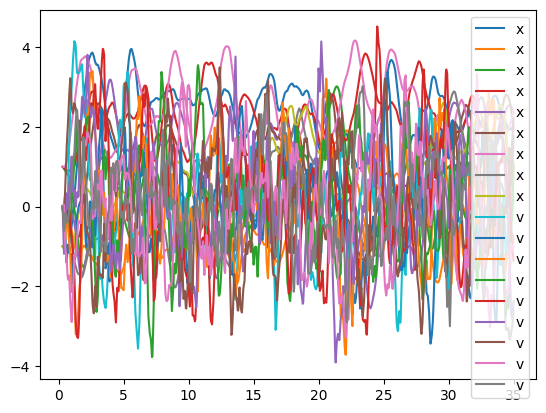

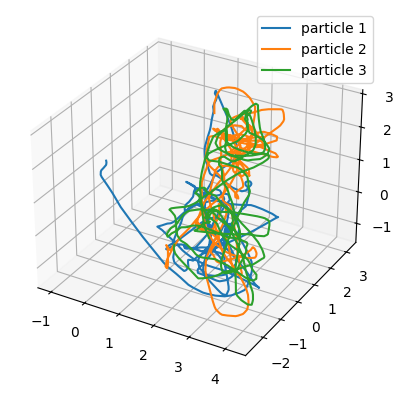

In [2]:
solShARK_uld3 = diffeqsolve(
    terms_uld3_long,
    ShARK(),
    t0,
    t_long,
    dt0=dt0,
    y0=uld3_long.y0,
    args=uld3_long.args,
    saveat=saveat_long,
)
plot_sol(solShARK_uld3)
plot_sol3D(solShARK_uld3)

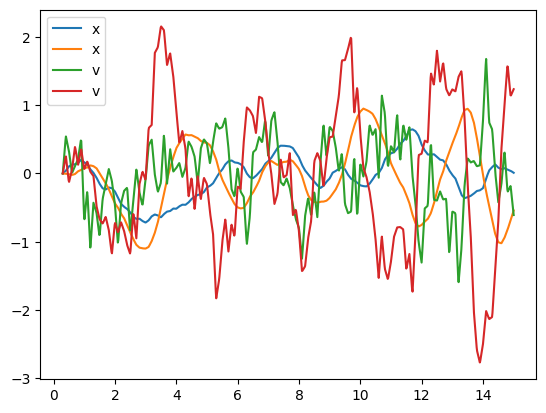

In [3]:
solShARK = diffeqsolve(
    terms_hosc, ShARK(), t0, t1, dt0=0.1, y0=hosc.y0, args=hosc.args, saveat=saveat
)
plot_sol(solShARK)

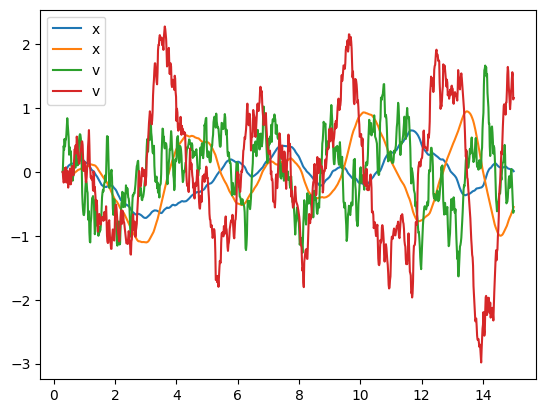

In [4]:
# ShARK uses an embeded method for error estimates,
# so it has native adaptive-stepping support
controller = PIDController(pcoeff=0.1, icoeff=0.3, rtol=0.005, atol=0.001)
solShARK_PID = diffeqsolve(
    terms_hosc,
    ShARK(),
    t0,
    t1,
    dt0=dt0,
    y0=hosc.y0,
    args=hosc.args,
    saveat=saveat,
    stepsize_controller=controller,
)
plot_sol(solShARK_PID)

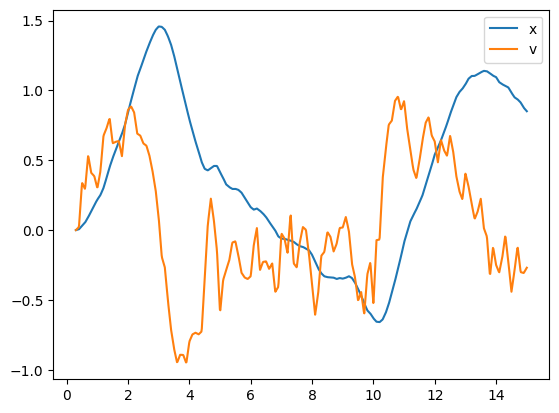

In [10]:
# Bistable Quartic Potential
solShARK_bqp = diffeqsolve(
    terms_bqp, ShARK(), t0, t1, dt0=dt0, y0=bqp.y0, args=bqp.args, saveat=saveat
)
plot_sol(solShARK_bqp)

### ShARK strong order
- vs StratonovichMilstein (as reference solver)
- vs itself

Afterwards we shall use ShARK as a reference solver for the other methods,
since it is faster the StratonovichMilstein.

Harmonic oscillator:


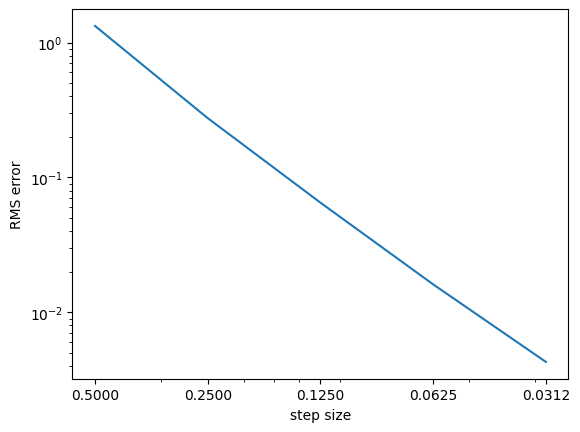

Order of convergence: 2.0643

BQP:


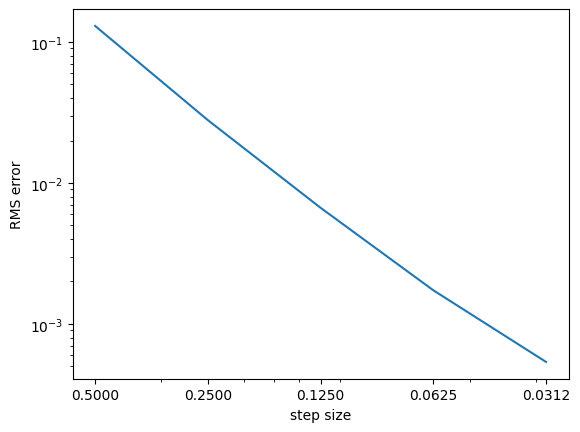

Order of convergence: 1.9853

ULD3:


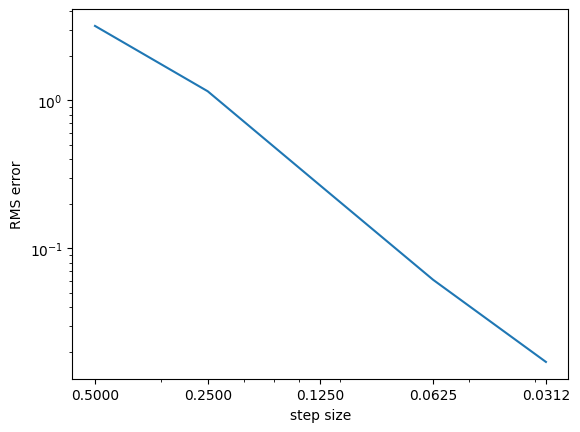

Order of convergence: 1.9321


In [3]:
print("Harmonic oscillator:")
hs, ShARK_errs_hosc, _ = sde_solver_order(
    keys, hosc_short, ShARK(), StratonovichMilstein(), 2**-12, dts=hs3
)
draw_order(hs, ShARK_errs_hosc)

print("\nBQP:")
hs, ShARK_errs_bqp, _ = sde_solver_order(
    keys, bqp_short, ShARK(), StratonovichMilstein(), 2**-12, dts=hs3
)
draw_order(hs, ShARK_errs_bqp)

print("\nULD3:")
hs, ShARK_errs_uld3, _ = sde_solver_order(
    keys, uld3_short, ShARK(), StratonovichMilstein(), 2**-12, dts=hs3
)
draw_order(hs, ShARK_errs_uld3)

Harmonic oscillator:


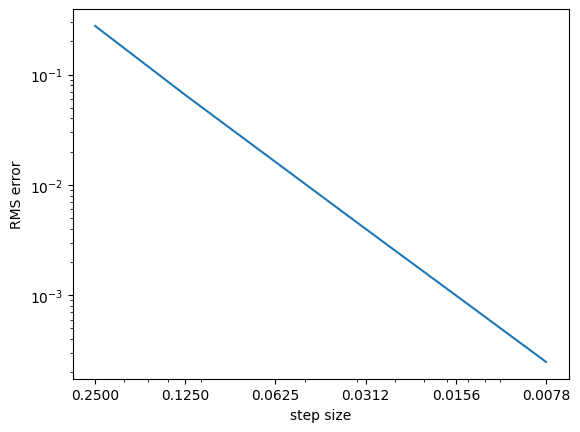

Order of convergence: 2.0191

BQP:


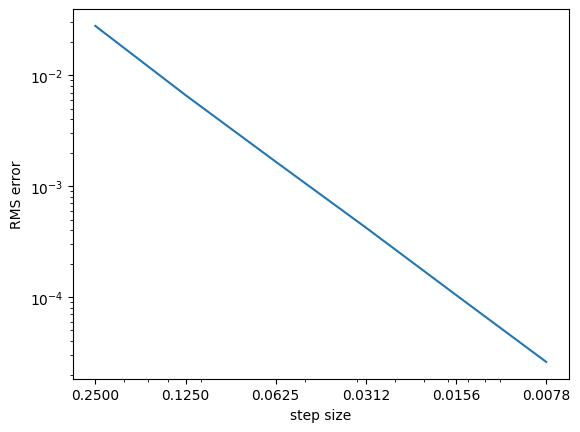

Order of convergence: 2.0083

ULD3:


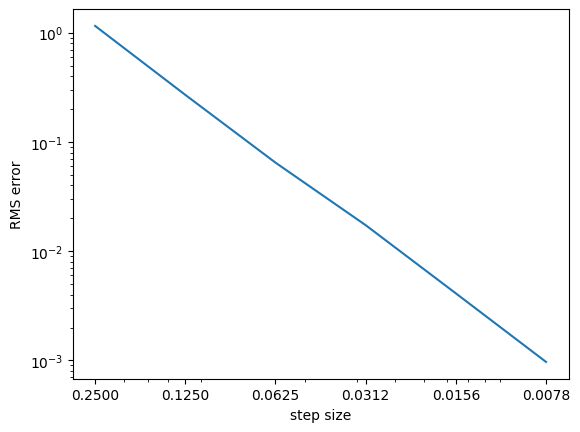

Order of convergence: 2.0321


In [3]:
print("Harmonic oscillator:")
hs, ShARK_errs_hosc, _ = sde_solver_order(
    keys, hosc_short, ShARK(), ShARK(), 2**-10, dts=hs1
)
draw_order(hs, ShARK_errs_hosc)

print("\nBQP:")
hs, ShARK_errs_bqp, _ = sde_solver_order(
    keys, bqp_short, ShARK(), ShARK(), 2**-10, dts=hs1
)
draw_order(hs, ShARK_errs_bqp)

print("\nULD3:")
hs, ShARK_errs_uld3, _ = sde_solver_order(
    keys, uld3_short, ShARK(), ShARK(), 2**-10, dts=hs1
)
draw_order(hs, ShARK_errs_uld3)

## SRA1
`SRA1` normally has strong order 1.5, but when applied to a Langevin SDE it has order 2. It natively supports adaptive-stepping via an embedded method for error estimation. Uses two evaluations of the vector-field per step.

Based on the SRA1 method from
    A. Rößler, Runge–Kutta methods for the strong approximation of solutions of stochastic differential equations,
    SIAM Journal on Numerical Analysis, 8 (2010), pp. 922–952.

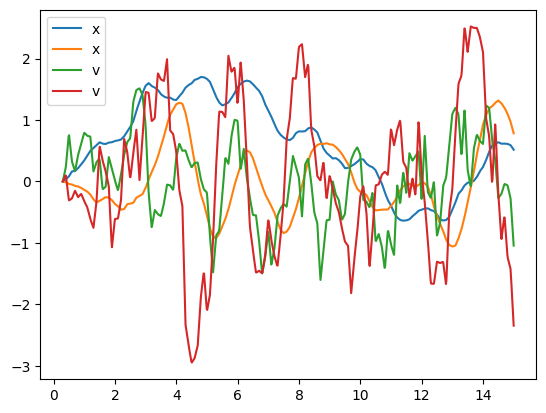

In [12]:
solSRA1 = diffeqsolve(
    terms_hosc, SRA1(), t0, t1, dt0=0.1, y0=hosc.y0, args=hosc.args, saveat=saveat
)
plot_sol(solSRA1)

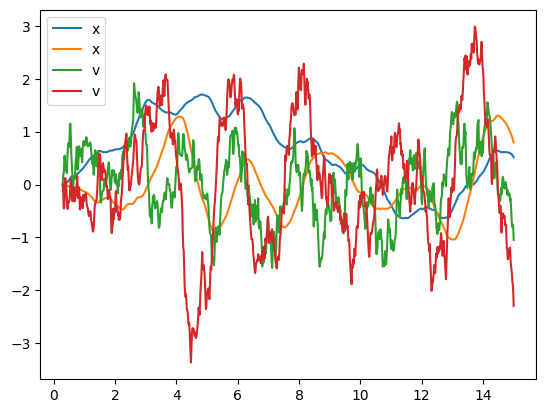

In [13]:
# SRA1 uses an embeded method for error estimates,
# so it has native adaptive-stepping support
controller = PIDController(pcoeff=0.1, icoeff=0.3, rtol=0.005, atol=0.001)
solSRA1_PID = diffeqsolve(
    terms_hosc,
    SRA1(),
    t0,
    t1,
    dt0=dt0,
    y0=hosc.y0,
    args=hosc.args,
    saveat=saveat,
    stepsize_controller=controller,
)
plot_sol(solSRA1_PID)

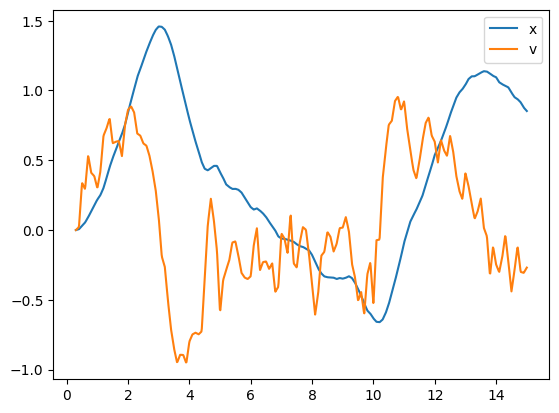

In [14]:
# Bistable Quartic Potential
solSRA1_bqp = diffeqsolve(
    terms_bqp, SRA1(), t0, t1, dt0=dt0, y0=bqp.y0, args=bqp.args, saveat=saveat
)
plot_sol(solSRA1_bqp)

Harmonic oscillator:


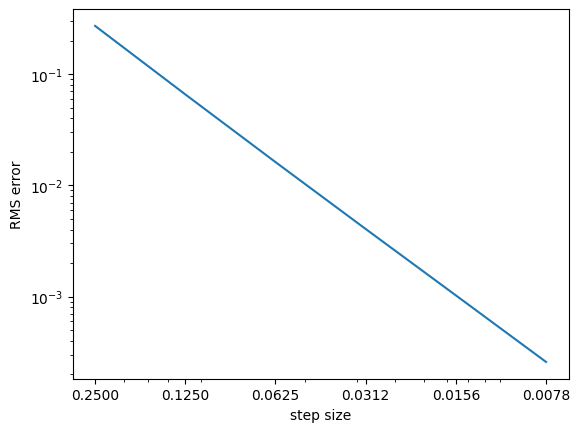

Order of convergence: 2.0040

BQP:


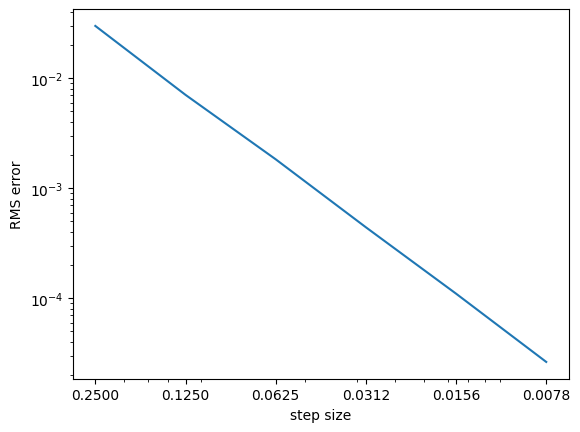

Order of convergence: 2.0224

ULD3:


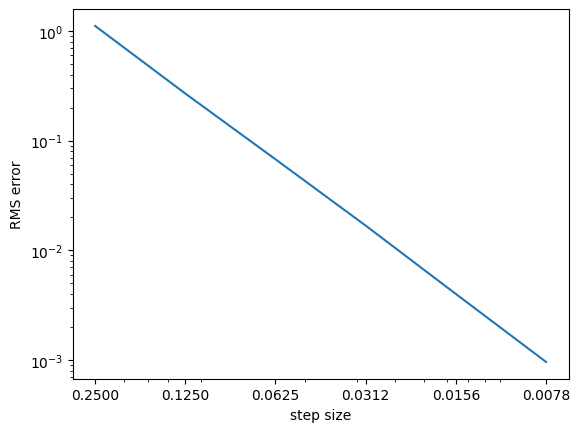

Order of convergence: 2.0318


In [4]:
print("Harmonic oscillator:")
hs, SRA1_errs_hosc, _ = sde_solver_order(
    keys, hosc_short, SRA1(), ShARK(), 2**-10, dts=hs1
)
draw_order(hs, SRA1_errs_hosc)

print("\nBQP:")
hs, SRA1_errs_bqp, _ = sde_solver_order(
    keys, bqp_short, SRA1(), ShARK(), 2**-10, dts=hs1
)
draw_order(hs, SRA1_errs_bqp)

print("\nULD3:")
hs, SRA1_errs_uld3, _ = sde_solver_order(
    keys, uld3_short, SRA1(), ShARK(), 2**-10, dts=hs1
)
draw_order(hs, SRA1_errs_uld3)

## Shifted Additive-noise Euler (SEA)
This variant of the Euler-Maruyama makes use of the space-time Levy area, which improves its local error to $O(h^2)$ compared to $O(h^{1.5})$ of the standard Euler-Maruyama. Nevertheless, it has a strong order of only 1 for additive-noise SDEs.

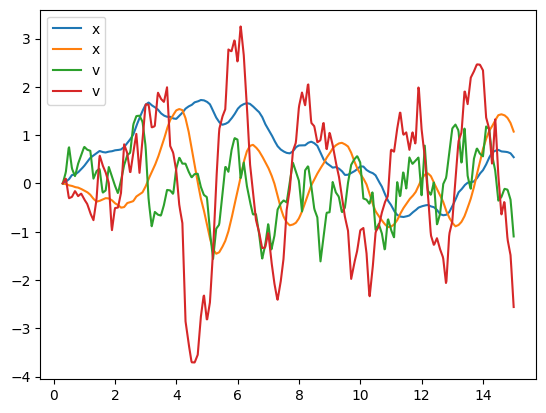

In [16]:
# Shifted Additive-noise Euler method
solSEA = diffeqsolve(
    terms_hosc, SEA(), t0, t1, dt0=0.1, y0=hosc.y0, args=hosc.args, saveat=saveat
)
plot_sol(solSEA)

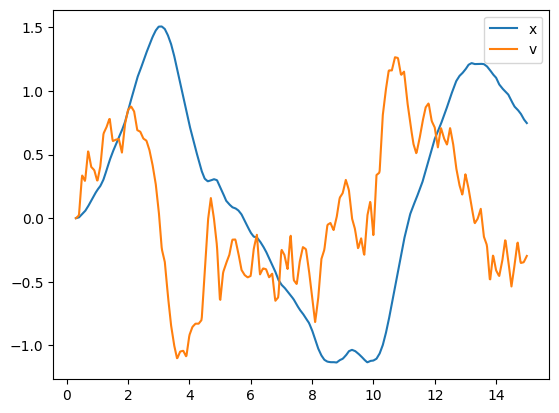

In [17]:
solSEA_bqp = diffeqsolve(
    terms_bqp, SEA(), t0, t1, dt0=dt0, y0=bqp.y0, args=bqp.args, saveat=saveat
)
plot_sol(solSEA_bqp)

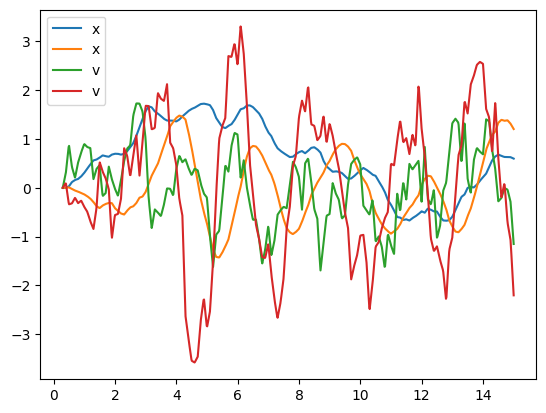

In [18]:
solEuler = diffeqsolve(
    terms_hosc, Euler(), t0, t1, dt0=0.1, y0=hosc.y0, args=hosc.args, saveat=saveat
)
plot_sol(solEuler)

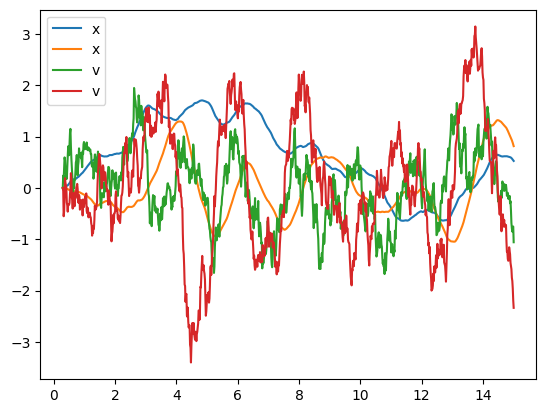

In [19]:
solPrecise = diffeqsolve(
    terms_hosc, Euler(), t0, t1, dt0=0.005, y0=hosc.y0, args=hosc.args, saveat=saveat
)
plot_sol(solPrecise)

Harmonic oscillator:


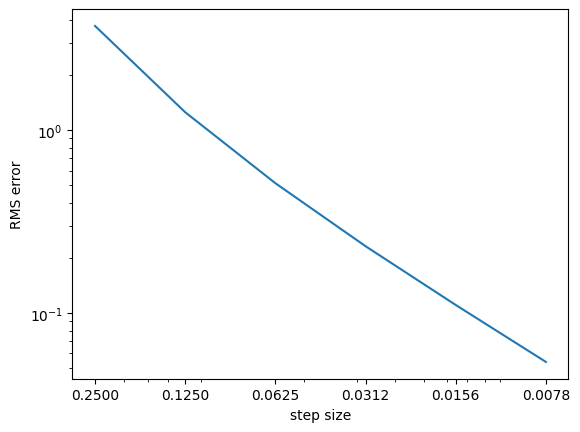

Order of convergence: 1.2048

BQP:


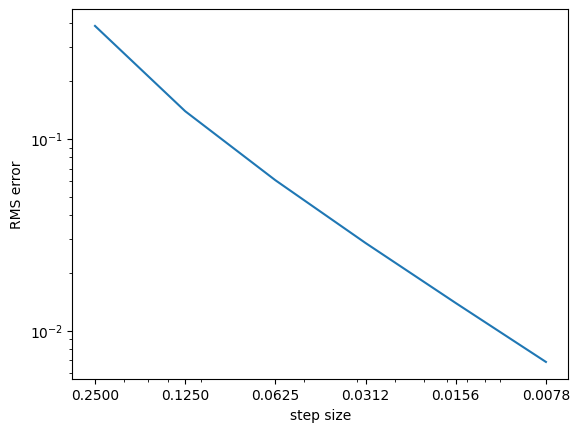

Order of convergence: 1.1472

ULD3:


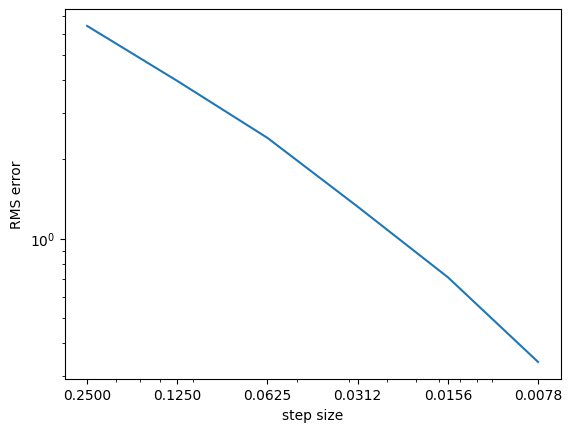

Order of convergence: 0.8429


In [5]:
print("Harmonic oscillator:")
hs, SEA_errs_hosc, _ = sde_solver_order(
    keys, hosc_short, SEA(), ShARK(), 2**-10, dts=hs1
)
draw_order(hs, SEA_errs_hosc)

print("\nBQP:")
hs, SEA_errs_bqp, _ = sde_solver_order(keys, bqp_short, SEA(), ShARK(), 2**-10, dts=hs1)
draw_order(hs, SEA_errs_bqp)

print("\nULD3:")
hs, SEA_errs_uld3, _ = sde_solver_order(
    keys, uld3_short, SEA(), ShARK(), 2**-10, dts=hs1
)
draw_order(hs, SEA_errs_uld3)